In [45]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from pprint import pprint
import pandas as pd
import gzip

In [46]:
%load_ext autoreload
%autoreload 1
%aimport models
%aimport main
%aimport data_utils
%aimport contrastive_data
%aimport scoring

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from contrastive_data import *
from data_utils import *
from main import *
from models import *
from scoring import *
from glob import glob

# Data and model

## Parameters

In [48]:
data_path = '/home/lguirardel/data/nabid_data/p53pilot/Data/RawData/filtered_feature_bc_matrix/wrangled'

In [213]:
run_dir = 'nabid_sc_1/nabid_sc_1_2'
run_name = run_dir.split('/')[1]
# BAG_SIZE = 50
dir_name = join('models',run_dir)
dataset_class = BatchDataset

In [214]:
params = pd.read_csv(f"models/{run_dir}/config.ini", sep=' = ', index_col=0, names=['value'], header=None).squeeze()
params

/tmp/ipykernel_11479/456122197.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  params = pd.read_csv(f"models/{run_dir}/config.ini", sep=' = ', index_col=0, names=['value'], header=None).squeeze()


dest-name                         nabid_sc_1
verbose                                    1
load-split           nabid_sc_1/nabid_sc_1_0
data-subset                         filtered
unseen-fraction                          0.0
loss                                standard
dropout                  0.03752599422354594
weight-decay             0.08314156860876377
batch-size                               512
shape                             [320, 320]
embed-dim                                 20
n-epochs                                 200
lr                      0.001856346754478017
scheduler                           restarts
cosine-t                                  91
task                              classifier
overwrite                               true
margin                                     1
alpha                                      0
positive-fraction                        0.5
patience                                  40
knn                                        5
bag-size  

## Loading

In [215]:
group_wt_like = False
paths = get_paths(data_path, subset = 'filtered')
if 'filter-variants' in params.index:
    variants_filt = pd.read_csv(params['filter-variants'], header=None).squeeze().str.upper()
else :
    variants_filt = None
counts = load_data(*paths, group_wt_like=group_wt_like, filt_variants=variants_filt, standardize=params['data-subset'] !='processed' )

	Reading files...
		Reading matrix
		Reading genes and cells
			Permuting gene columns to match gene file
		Reading variant data
	Merging and processing...
		Removing low variance genes and standardizing data
		 1180 genes with std < 1.0e-03 dropped
		10 variant classes


In [216]:
counts.variant.value_counts()

variant
eGFP             909
P53.BC2          645
R175H.P53.BC5    510
P53.BC1          469
EV.BC9           458
R175H.P53.BC7    350
P53.BC3          278
R175H.P53.BC6    225
P53.BC4          195
R175H.P53.BC8    190
Name: count, dtype: int64

In [217]:
df_train, df_seen, df_unseen = load_split(join(dir_name, 'split'), counts, )
df_dict = {
    'train':df_train,
    'seen':df_seen,
    'unseen':df_unseen,
}

3172, 1057, 0 exemples in data
10 variants in train
0 variants in unseen


In [218]:
counts.variant = counts.variant.cat.remove_unused_categories() # remove unused variants due to variant filtering

In [219]:
dl_train, dl_seen, dl_unseen = make_loaders(
    df_train, df_seen,df_unseen, batch_size=64, dataset_class=dataset_class,n_workers=1,pos_frac=0.5, 
    # dataset_kwargs={'bag_size':BAG_SIZE}
    )
dl_dict = {
    'train':dl_train,
    'seen':dl_seen,
    'unseen':dl_unseen,
}

In [220]:
model :Model = torch.load(join(dir_name,'best_model.pkl'), map_location='cpu')
model.eval()

Classifier(
  (network): MLP(
    (layers): Sequential(
      (0): Linear(in_features=26179, out_features=320, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.03752599422354594, inplace=False)
      (3): Linear(in_features=320, out_features=320, bias=True)
      (4): ELU(alpha=1.0)
      (5): Dropout(p=0.03752599422354594, inplace=False)
      (6): Linear(in_features=320, out_features=20, bias=True)
    )
  )
  (output_layer): Linear(in_features=20, out_features=10, bias=True)
)

In [221]:
df_train.shape

(3172, 26182)

In [222]:
!cat models/{run_dir}/best_score.json

{
  "5_nn_ref_seen": 0.6944181646168401,
  "i": 109
}

In [223]:
fclass = df_seen[['variant','Variant functional class']].value_counts()\
    .reset_index('Variant functional class').drop(columns='count').squeeze()
fclass

variant
eGFP                  Control
P53.BC2               WT-like
R175H.P53.BC5    Impactful II
EV.BC9                Control
P53.BC1               WT-like
R175H.P53.BC7    Impactful II
P53.BC3               WT-like
R175H.P53.BC8    Impactful II
R175H.P53.BC6    Impactful II
P53.BC4               WT-like
Name: Variant functional class, dtype: object

In [224]:
conditions = pd.read_csv('~/data/nabid_data/p53pilot/Data/conditions.csv', index_col=0)
conditions = conditions.rename(columns = {f'P53.BC{i}':f'R175H.P53.BC{i}' for i in range(5,9)})

## Compute embeddings

In [225]:
def get_X(df):
    return df.drop(columns=['variant','Variant functional class','cycle' ])

In [226]:
emb_dict = {}
for k, df in df_dict.items():
    with torch.no_grad():
        X = torch.tensor(get_X(df).to_numpy(), dtype=torch.float32)[:, None, None, :] #(B, 1, 1, d)
        embeds = model.network.embed(X).squeeze()

    # emb_dict[k] = (embeds - embeds.mean(dim=0, keepdim=True)) / embeds.norm(dim=0, keepdim=True) # no : we want plots to represent distances in embed space 
    emb_dict[k] = embeds    

In [227]:
dims = [20, 70, 150]


In [228]:
pca_dict = {}
for n in dims:
    pca = PCA(n_components=n).fit(get_X(df_train))
    pca_dict[n] = {
        'train': pca.transform(get_X(df_train)),
        'seen': pca.transform(get_X(df_seen)),
    }

In [229]:
best_genes = pd.read_csv(f'deeplift/out/{max(dims)}_best_genes.csv', index_col=0)
genes_dict = {}
for n in dims:
    genes_dict[n] = {
        'train':df_train[best_genes.index[:n]],
        'seen':df_seen[best_genes.index[:n]],
    }

In [230]:
red_dict = {'embed':emb_dict, }
red_dict.update({f'pca_{n}':pca_dict[n] for n in dims})
red_dict.update({f'genes_{n}':genes_dict[n] for n in dims})


# Embed PCA

In [231]:
pca = PCA(2).fit(emb_dict['seen'])

# Embedding distribution

In [232]:
make_dir_if_needed(f'plots/embeds/{run_name}')

In [233]:
hue_order = ['Control','WT-like', 'Impactful II',]


In [234]:
subset = 'seen'
df = df_dict[subset]
embeds = emb_dict[subset]
emb_red = pca.transform(embeds)


In [235]:
print(f'Explained variance : {(pca.explained_variance_ratio_).sum()*100:.1f} %')


Explained variance : 46.8 %


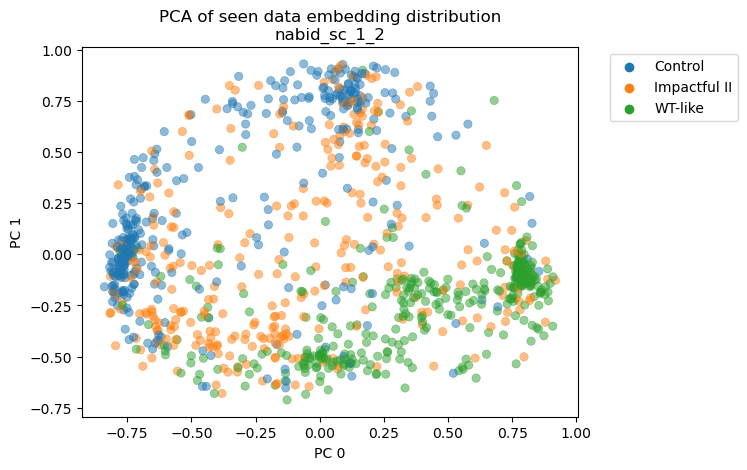

In [236]:
## SCATTER PLOT - WT-SYN VS OTHERS
hue = df['variant'].map(fclass)
ax = sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue =hue, 
                alpha=0.1 if subset=='train' else 0.5, legend=True,
                edgecolor=None
                )
# sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue =hue, 
#             levels=5, common_norm=False, )
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
# put legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_fclass.pdf')

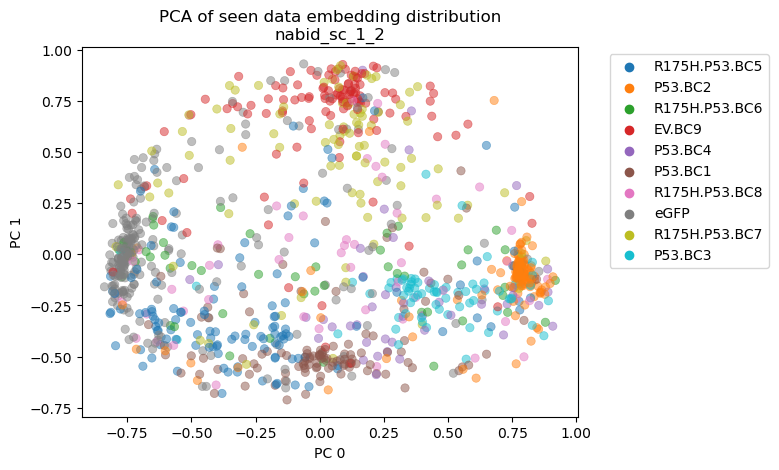

In [237]:
hue = df['variant']
ax = sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue =hue, 
                alpha=0.1 if subset=='train' else 0.5, legend=True,
                edgecolor=None
                )
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
# put legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_variant.pdf')

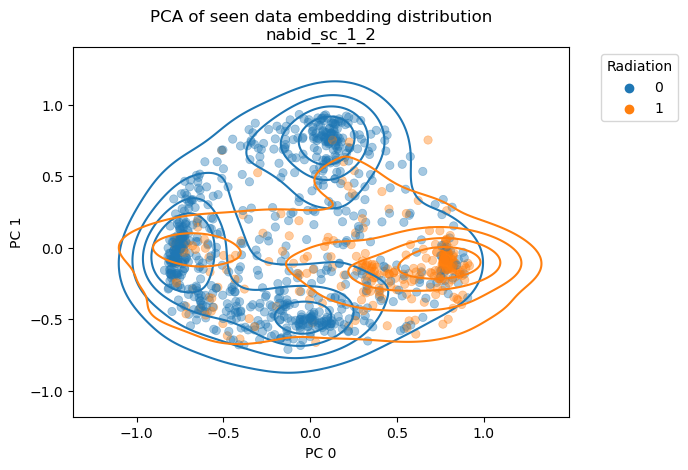

In [238]:
hue = conditions.loc['Radiation'][df['variant']]
ax = sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue =hue, 
                alpha=0.1 if subset=='train' else 0.4, legend=True,
                edgecolor=None
                )
sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1],  hue =hue, 
            levels=5, common_norm=False, legend = False)

plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
# put legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=hue.name)
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_radiation.pdf')

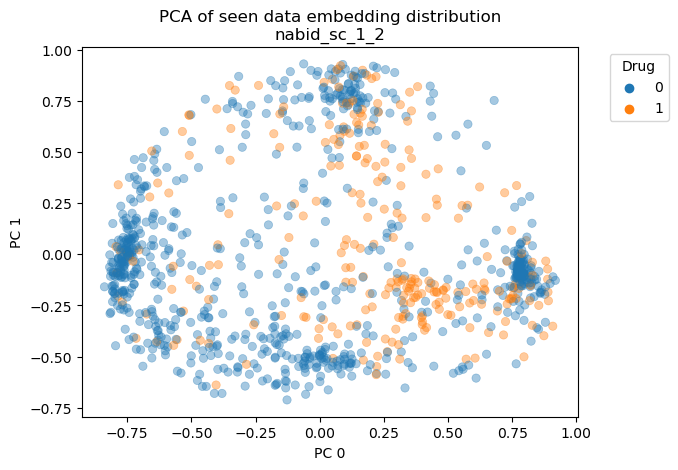

In [239]:
hue = conditions.loc['Drug'][df['variant']]
ax = sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue =hue, 
                alpha=0.1 if subset=='train' else 0.4, legend=True,
                edgecolor=None
                )
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
# put legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=hue.name)
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_drug.pdf')

# kNN scores

This section compares the embedding with :
- PCA (20 dim, 150 dim)
- 150 best DeepLIFT genes (as identified in my internship thesis)
- Full transcriptome

### PCA 

In [240]:
make_dir_if_needed(f'plots/scores/{run_name}')

## ref knn

### Score

This score needs a reference (training) and a test set (seen). We do not use unseen variants as this is the ref-knn score.

In [241]:
K=5
knn = KNeighborsClassifier(K)

y_train = df_train['variant']
y_test = df_seen['variant']
score_dict = {}
print(f"{K}-nn scores ({run_name})")
for name, d in red_dict.items():
    train, test = d['train'], d['seen']
    knn.fit(train, y_train)
    y_pred = knn.predict(test)
    s = accuracy_score(y_test, y_pred)
    score_dict[name] = s
    print(f'\t{name}\t{s:.3f}')


5-nn scores (nabid_sc_1_2)
	embed	0.694
	pca_20	0.336
	pca_70	0.428
	pca_150	0.417
	genes_20	0.247
	genes_70	0.296
	genes_150	0.335


## self knn

### Score

In [248]:
subset = 'seen'
dl = dl_seen

model_ = model.network
device = 'cuda'
model_.eval()
model_ = model_.to(device)
embed, y_true, x_cell = [], [], []
for x,y in dl: # x,y are tuples of tensors of any size, we're taking the first one
    with torch.no_grad():
        embed.append(model_.embed(x[0].to(device)).cpu().squeeze())
        y_true.append(y[0])
        x0 = x[0].squeeze()
        if len(x[0].shape) > 2:
            x_cell.append(x0.mean(1))
        else:
            x_cell.append(x0)
embed = torch.concat(embed)
y_true = torch.concat(y_true)
x_red = PCA(20).fit_transform(torch.concat(x_cell))


In [249]:
knn = KNeighborsTransformer(n_neighbors=K)
y_true = y_true.cpu().numpy()
knn.fit(embed.cpu(), )
graph = knn.kneighbors_graph()
y_pred = y_true[find(graph)[1]] # neighbors' y (find(graph)[1] are the target nodes in the knn graph)
y_pred = y_pred.reshape((-1, K)) # (kN, ) -> (N, k)
y_pred = mode(y_pred.T).mode
s= accuracy_score(y_true, y_pred)

In [250]:
knn.fit(x_red, )
graph = knn.kneighbors_graph()
y_pred_pca = y_true[find(graph)[1]] # neighbors' y (find(graph)[1] are the target nodes in the knn graph)
y_pred_pca = y_pred_pca.reshape((-1, K)) # (kN, ) -> (N, k)
y_pred_pca = mode(y_pred_pca.T).mode
s_pca = accuracy_score(y_true, y_pred_pca)

In [251]:
n_max = np.unique(y_true, return_counts=True)[1].max()
n_cell = len(y_true)
print(f'Score {s*100:.2f} % ({K}-nn). Best constant predictor : {100*n_max/n_cell:.2f} %. Score PCA : {s_pca*100:.2f} %')

Score 66.70 % (5-nn). Best constant predictor : 22.23 %. Score PCA : 26.30 %


### Confusion matrix

Text(0.5, 1.0, 'Confusion matrix in % of true labels\nself seen')

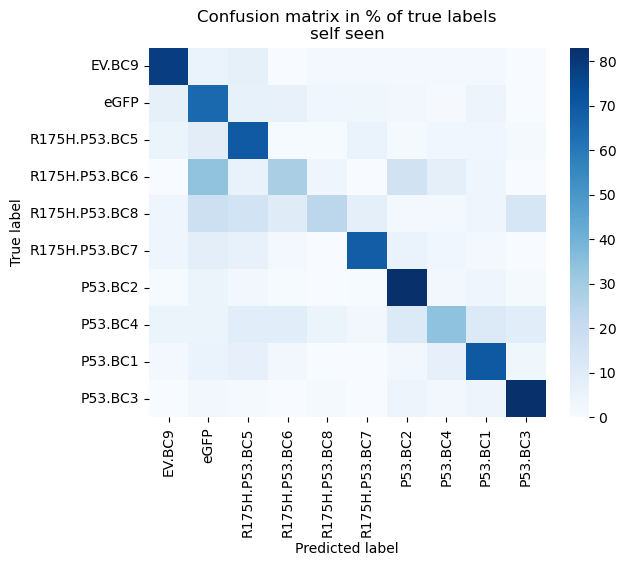

In [252]:

confusion = confusion_matrix(y_true, y_pred)
confusion = pd.DataFrame(confusion, index=dl_train.dataset.cats[sl], columns=dl_train.dataset.cats[sl])  
confusion.index.name = 'True label'
confusion.columns.name = 'Predicted label'

confusion = pd.concat([group for _, group in confusion.groupby(fclass)])
confusion = pd.concat([group for _, group in confusion.T.groupby(fclass)]).T
confusion = confusion.div(confusion.sum(axis=1), axis=0)*100

# seaborn plot
sns.heatmap(confusion, annot=False, fmt='d', cmap='Blues',)
plt.title(f'Confusion matrix in % of true labels\nself {subset}')

In [253]:
pd.Series(np.diag(confusion), index = confusion.index).sort_values(ascending=False) 

True label
P53.BC3          83.098592
P53.BC2          82.781457
EV.BC9           78.512397
P53.BC1          69.911504
R175H.P53.BC5    69.600000
R175H.P53.BC7    68.750000
eGFP             65.106383
P53.BC4          34.090909
R175H.P53.BC6    28.000000
R175H.P53.BC8    23.529412
dtype: float64

# LogReg scores

In [254]:
from sklearn.linear_model import LogisticRegression

In [269]:
cls = LogisticRegression(max_iter=500)

y_train = df_train['variant']
y_test = df_seen['variant']
score_dict = {}
result = f'Logreg scores ({run_name}): \n' # more legible if error message are thrown
for name, d in red_dict.items():
    train, test = d['train'], d['seen']
    cls.fit(train, y_train)
    y_pred = cls.predict(test)
    s = accuracy_score(y_test, y_pred)
    score_dict[name] = s
    result+=(f'\t{name}\t{s:.3f}\n')
print(result)

/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Logreg scores (nabid_sc_1_2): 
	embed	0.686
	pca_20	0.445
	pca_70	0.656
	pca_150	0.674
	genes_20	0.329
	genes_70	0.487
	genes_150	0.554



# Clustering

In [256]:
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
make_dir_if_needed(f'plots/clustering/{run_name}')

## KMEANS clustering of embeddings

### Evaluate number of clusters

In [257]:
emb_dict['seen'].shape

torch.Size([1057, 20])

In [258]:
s = []
c = []
for i in tqdm(range(2,20)):
    kmeans = KMeans(n_clusters=i)
    labels = kmeans.fit_predict(emb_dict['seen'])
    s.append(silhouette_score(emb_dict['seen'], labels))
    c.append(kmeans.inertia_)


100%|██████████| 18/18 [00:03<00:00,  5.26it/s]


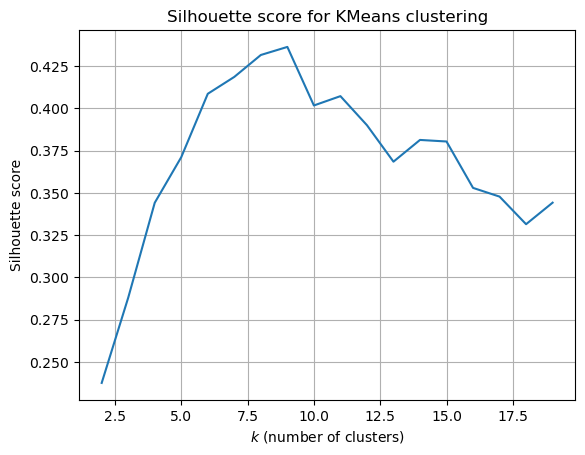

In [259]:
plt.plot(range(2,len(s)+2),s)
plt.title('Silhouette score for KMeans clustering')
plt.xlabel('$k$ (number of clusters)')
plt.ylabel('Silhouette score')
plt.grid()
plt.savefig(f'plots/clustering/{run_name}/silhouette_score.pdf')

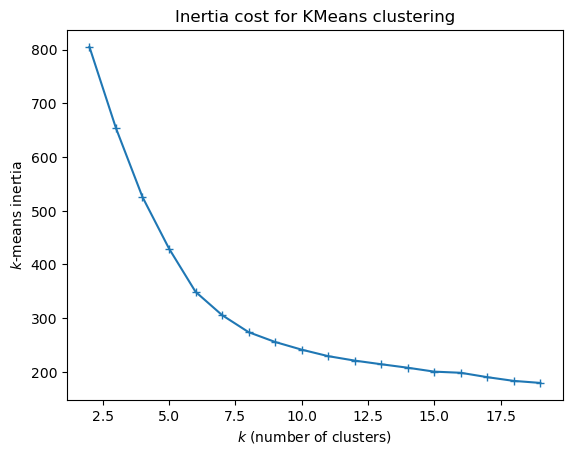

In [260]:
plt.plot(range(2,len(c)+2),c, '+-')
plt.title('Inertia cost for KMeans clustering')
plt.xlabel('$k$ (number of clusters)')
plt.ylabel('$k$-means inertia')
plt.savefig(f'plots/clustering/{run_name}/{run_name}_inertia.pdf')

10 clusters, 10 conditions

### Plot cluster

In [261]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=4)
labels = kmeans.fit_predict(emb_dict['seen'])
emb_red = pca.transform(emb_dict['seen'])

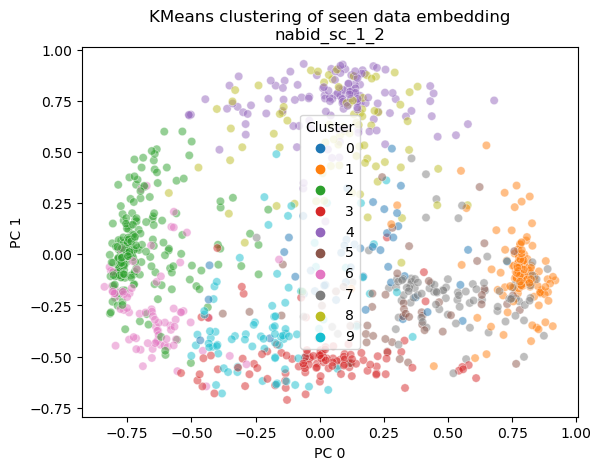

In [262]:
# scatter plot
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = labels, palette='tab10', alpha=0.5, legend=True)
plt.legend(title='Cluster')
plt.title(f'KMeans clustering of seen data embedding\n{run_name}')
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
# legend outside plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f'plots/clustering/{run_name}/{run_name}_kmeans_scatter.pdf')

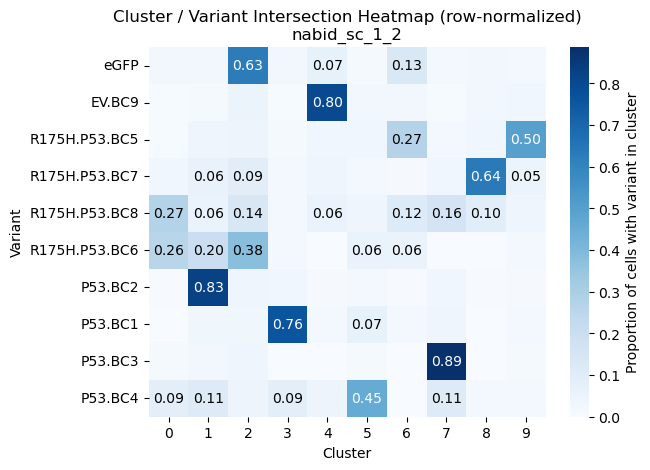

In [263]:
# main_var_only = False # set to False to include all variants
# Create a dataframe with cluster labels and variant names
df_heatmap = pd.DataFrame({'Cluster': labels, 'Variant': df_seen['variant']})

# Pivot the dataframe to create a matrix of cluster-variant intersection
heatmap_data = df_heatmap.pivot_table(index='Cluster', columns='Variant', aggfunc=len, fill_value=0).T
heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) # normalize by row
heatmap_data = heatmap_data.reindex(fclass.index)

heatmap_data = pd.concat([group for _, group in heatmap_data.groupby(fclass)])

# Create the heatmap
heatmap = sns.heatmap(heatmap_data, cmap='Blues', vmin=0,
                      )
heatmap.set_title('Cluster / Variant Intersection Heatmap (row-normalized)\n'+run_name)
heatmap.set_xlabel('Cluster')
heatmap.set_ylabel('Variant')
cbar = heatmap.collections[0].colorbar
cbar.set_label('Proportion of cells with variant in cluster')

# Add annotations to the heatmap

for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        value = heatmap_data.iloc[i, j]
        if value > 0.05:
            heatmap.annotate(f'{value:.2f}', (j + 0.5, i + 0.5), ha='center', va='center',
                            color = 'black' if value < cbar.vmax/2 else 'white'
                            )
plt.savefig(f'plots/clustering/{run_name}/{run_name}_cluster_variant_heatmap_row.pdf')


# Embedding PCA variance plot

In [264]:
df_seen.drop(columns=['cycle','Variant functional class', 'variant']).std()

ENSG00000000003    9.593887e-01
ENSG00000000005    4.442994e-16
ENSG00000000419    1.047634e+00
ENSG00000000457    9.840548e-01
ENSG00000000460    1.009700e+00
                       ...     
ENSG00000288235    4.442994e-16
ENSG00000288253    1.077820e+00
ENSG00000288380    1.048204e+00
ENSG00000288398    1.044501e+00
ENSG00000288460    4.200018e-16
Length: 26179, dtype: float64

X_norm shape (3172, 26179)


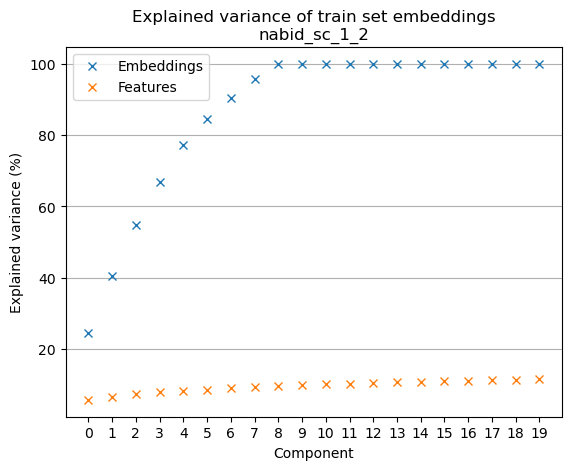

In [265]:
subset='train'
embeds = emb_dict[subset]

n = embeds.size(1)
embeds_norm = (embeds - embeds.mean(-1, keepdim=True))/embeds.std(-1, keepdim=True)
X_norm = df_dict[subset].drop(columns=['variant','Variant functional class','cycle' ])
X_norm = ((X_norm - X_norm.mean())/X_norm.std()).dropna(axis=1) # drop columns with 0 variance
print('X_norm shape', X_norm.shape)
pca_2 = PCA(n).fit(embeds_norm)
pca_X = PCA(n).fit(X_norm)
plt.plot(range(n), 100* np.cumsum(pca_2.explained_variance_ratio_), 'x', label='Embeddings')
plt.plot(range(n), 100* np.cumsum(pca_X.explained_variance_ratio_), 'x', label='Features')
plt.legend()
plt.ylabel('Explained variance (%)')
plt.xlabel('Component')
plt.title(f'Explained variance of {subset} set embeddings\n{run_name}')
plt.grid(axis='y')
plt.xticks(range(n))
plt.savefig(f'plots/embeds/{run_name}/embed_pca_variance.pdf');

# Comparison with simple PCA

In [266]:
def normalize(df):
    return (df - df.mean())/df.std()

In [267]:
subset = 'seen'
pca_base = PCA(2).fit(normalize(df_train.iloc[:,:-3]))

df = df_dict[subset]
X_red = pca_base.transform(normalize(df.iloc[:,:-3]))


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
print(f'Explained variance : {(pca_base.explained_variance_ratio_).sum()*100:.1f} %')


Explained variance : 5.1 %


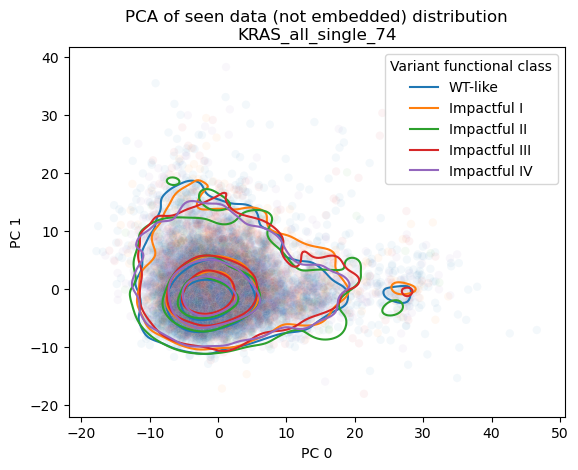

In [ ]:
sns.scatterplot(x=X_red[:,0], y=X_red[:,1], hue = df['Variant functional class'], hue_order=hue_order, alpha=0.05, legend=False)
sns.kdeplot(x=X_red[:,0], y=X_red[:,1], hue = df['Variant functional class'], hue_order=hue_order, levels=4, common_norm=False)
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data (not embedded) distribution\n{run_name}' )
plt.savefig(f'plots/embeds/{run_name}/{subset}_pca_kde.pdf')

Text(0.5, 1.0, 'PCA of WT, R273C embedding distribution\ncls_tp53_0_best, seen')

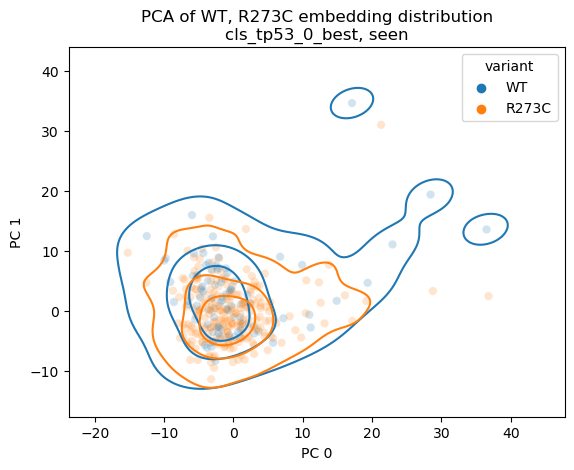

In [ ]:
variants = ['WT', 'R273C']
# variant = 'C277F'
# df2 = df[f]
# variant_list = df2.variant.unique()

hue = df.variant.map(lambda x : x if x in variants else 'Other')

f = hue != 'Other'

sns.kdeplot(x=X_red[f,0], y=X_red[f,1], hue =hue[f], legend=False, common_norm=False, levels = 4,
            hue_order=variants
            )

# hue = df['cycle'][f]
sns.scatterplot(x=X_red[f,0], y=X_red[f,1], hue =hue[f],  alpha=0.2, legend=True,
            hue_order=variants
            )



plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {", ".join(variants)} embedding distribution\n{run_name}, {subset}' )
# plt.savefig(f'plots/embeds/{run_name}/{subset}_variants_refpca_kde.pdf')

In [ ]:
df.iloc[:,:-3].std(axis=0).sort_values()

NTS              0.726865
RP11-338I21.1    0.735849
LINC01220        0.846769
SCG2             0.873338
VCAN             0.889288
                   ...   
CCL26            1.021527
FBXO32           1.021564
RTN2             1.025186
AC006262.5       1.035991
GACAT2           1.043334
Length: 1145, dtype: float64